Building Benchmark Model for FD002 Dataset
1. Load CMAPSS FD002
2. Create RUL and warning labels
3. Leakage-free train/val split by engine
4. Scaling
5. Baseline Random Forest (RUL regression & warning classification)
6. Metrics for CM1 report

## 0. Imports / setup
Install dependencies if needed:
```bash
pip install pandas scikit-learn numpy matplotlib
```

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt


## 1. Load CMAPSS FD002 data
- `CMAPSSData (1).zip` should be next to this notebook (or update the path).
- We extract it and load `train_FD002.txt`, `test_FD002.txt`, `RUL_FD002.txt`. 


In [2]:
zip_path = 'CMAPSSData.zip'  # change if needed
extract_dir = 'cmapss_extracted'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)

train_path = os.path.join(extract_dir, 'train_FD002.txt')
test_path  = os.path.join(extract_dir, 'test_FD002.txt')
rul_path   = os.path.join(extract_dir, 'RUL_FD002.txt')

train_raw = pd.read_csv(train_path, sep=r'\s+', header=None)
test_raw  = pd.read_csv(test_path,  sep=r'\s+', header=None)
rul_raw   = pd.read_csv(rul_path,   sep=r'\s+', header=None)

print('train shape:', train_raw.shape)
print('test shape :', test_raw.shape)
print('rul shape  :', rul_raw.shape)
train_raw.head()

train shape: (53759, 26)
test shape : (33991, 26)
rul shape  : (259, 1)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## 2. Label engineering (RUL + warning_flag)
We name the columns and compute:
- RUL = max_cycle(engine) - current_cycle
- warning_flag = 1 if RUL <= 30 cycles else 0

In [3]:
columns = [
    'engine_id', 'cycle',
    'os1', 'os2', 'os3',
] + [f's{i}' for i in range(1,22)]

train_raw.columns = columns
test_raw.columns  = columns

# max cycle per engine (failure point)
max_cycles = train_raw.groupby('engine_id')['cycle'].max()

# merge so each row knows that engine's final cycle
train_with_rul = train_raw.merge(
    max_cycles,
    on='engine_id',
    suffixes=('', '_max')
)

# compute RUL
train_with_rul['RUL'] = train_with_rul['cycle_max'] - train_with_rul['cycle']

# define early warning classification label
threshold = 30
train_with_rul['warning_flag'] = (train_with_rul['RUL'] <= threshold).astype(int)

train_with_rul[['engine_id','cycle','RUL','warning_flag']].head(10)

,engine_id,cycle,RUL,warning_flag
0,1,1,148,0
1,1,2,147,0
2,1,3,146,0
3,1,4,145,0
4,1,5,144,0
5,1,6,143,0
6,1,7,142,0
7,1,8,141,0
8,1,9,140,0
9,1,10,139,0


## 3. Train/Validation split (no leakage)
We split by engine_id, not by rows, so validation engines were never seen in training.

In [4]:
engines = train_with_rul['engine_id'].unique()
eng_train, eng_val = train_test_split(
    engines,
    test_size=0.2,
    random_state=42
)

train_df = train_with_rul[train_with_rul['engine_id'].isin(eng_train)].reset_index(drop=True)
val_df   = train_with_rul[train_with_rul['engine_id'].isin(eng_val)].reset_index(drop=True)

print('Train engines:', len(eng_train), ' Val engines:', len(eng_val))
print('Train rows:', train_df.shape, ' Val rows:', val_df.shape)
train_df.head()

Train engines: 208  Val engines: 52
Train rows: (43464, 29)  Val rows: (10295, 29)


,engine_id,cycle,os1,os2,os3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_max,RUL,warning_flag
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,9.3461,0.02,334,2223,100.00,14.73,8.8071,149,148,0
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,9.3774,0.02,330,2212,100.00,10.41,6.2665,149,147,0
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,10.8941,0.02,309,1915,84.93,14.08,8.6723,149,146,0
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,9.3528,0.02,329,2212,100.00,10.59,6.4701,149,145,0
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,10.8963,0.02,309,1915,84.93,14.13,8.5286,149,144,0


## 4. Feature scaling
We z-score normalize os1-3 and s1-s21 using only training stats, then apply to validation.

In [5]:
feature_cols = [c for c in train_df.columns if c.startswith('os') or c.startswith('s')]

X_train = train_df[feature_cols].values
X_val   = val_df[feature_cols].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

y_train_rul = train_df['RUL'].values
y_val_rul   = val_df['RUL'].values

y_train_cls = train_df['warning_flag'].values
y_val_cls   = val_df['warning_flag'].values

len(feature_cols), feature_cols[:10]

(24, ['os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7'])

## 5. Baseline Models
### 5.1 Random Forest Regressor for RUL
We predict remaining useful life as a continuous value.

We evaluate with RMSE and R².

In [6]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models_reg = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM (RBF)": SVR(kernel='rbf', C=100, gamma=0.01),
    "kNN": KNeighborsRegressor(n_neighbors=5)
}

results_reg = []

for name, model in models_reg.items():
    model.fit(X_train_scaled, y_train_rul)
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val_rul, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_rul, y_pred)
    results_reg.append((name, rmse, r2))

print("=== Regression Results ===")
for name, rmse, r2 in results_reg:
    print(f"{name:15s} | RMSE: {rmse:7.2f} | R²: {r2:6.3f}")


=== Regression Results ===
Random Forest   | RMSE:   41.43 | R²:  0.603
SVM (RBF)       | RMSE:   41.35 | R²:  0.605
kNN             | RMSE:   45.43 | R²:  0.523


### 5.2 Random Forest Classifier for Maintenance Warning
warning_flag = 1 means RUL <= threshold cycles (we used 30).

We evaluate with accuracy, confusion matrix, precision, recall, F1.

In [7]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# We'll compare different classifiers on the same scaled features
models_clf = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma=0.01),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results_clf = []

for name, model in models_clf.items():
    # train on training engines only
    model.fit(X_train_scaled, y_train_cls)

    # predict on unseen engines
    y_pred = model.predict(X_val_scaled)

    # compute metrics for the "warning" class = 1
    acc  = accuracy_score(y_val_cls, y_pred)
    prec = precision_score(y_val_cls, y_pred)
    rec  = recall_score(y_val_cls, y_pred)
    f1   = f1_score(y_val_cls, y_pred)

    results_clf.append((name, acc, prec, rec, f1))

print("=== Classification Results ===")
for name, acc, prec, rec, f1 in results_clf:
    print(f"{name:20s} | Acc: {acc:6.3f} | Prec: {prec:6.3f} | Rec: {rec:6.3f} | F1: {f1:6.3f}")



=== Classification Results ===
Random Forest        | Acc:  0.956 | Prec:  0.905 | Rec:  0.802 | F1:  0.851
SVM (RBF)            | Acc:  0.949 | Prec:  0.909 | Rec:  0.752 | F1:  0.823
kNN                  | Acc:  0.949 | Prec:  0.876 | Rec:  0.784 | F1:  0.827
Logistic Regression  | Acc:  0.948 | Prec:  0.898 | Rec:  0.751 | F1:  0.818


## 6. Confusion Matrix Heatmap (nice for slides)
This cell draws a normalized confusion matrix with raw counts + %.

=== Random Forest ===


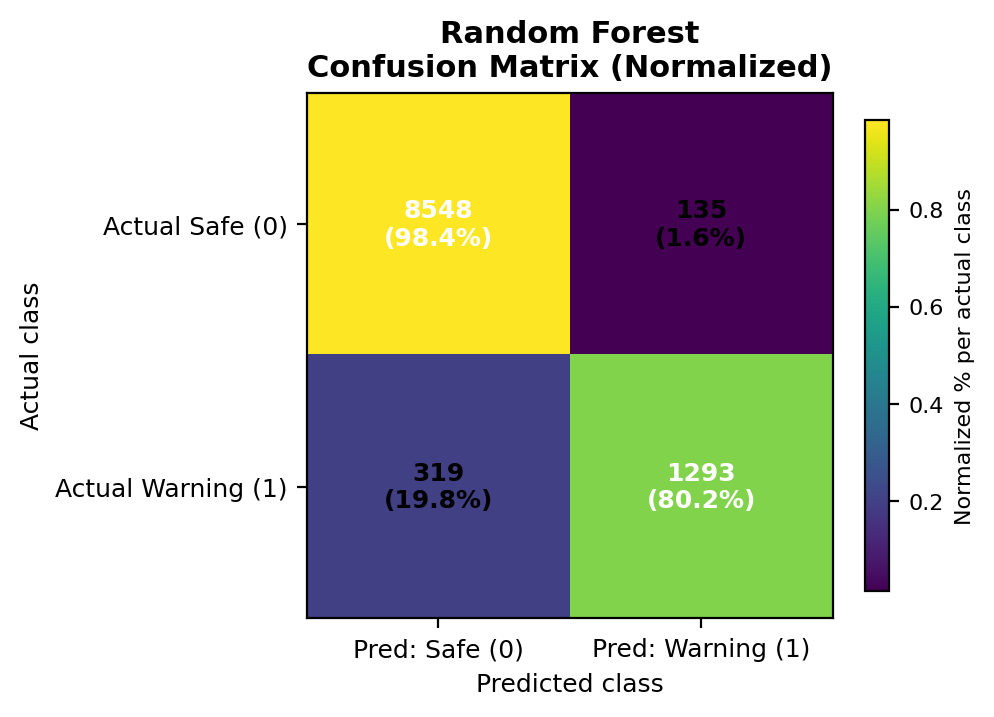

=== SVM (RBF) ===


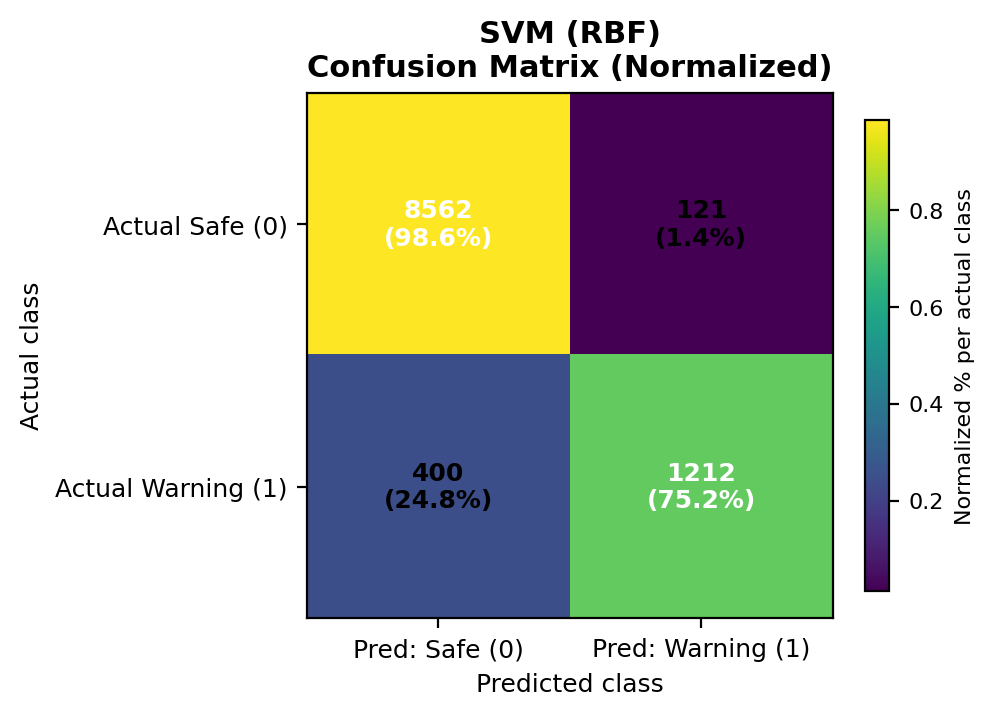

=== kNN (k=5) ===


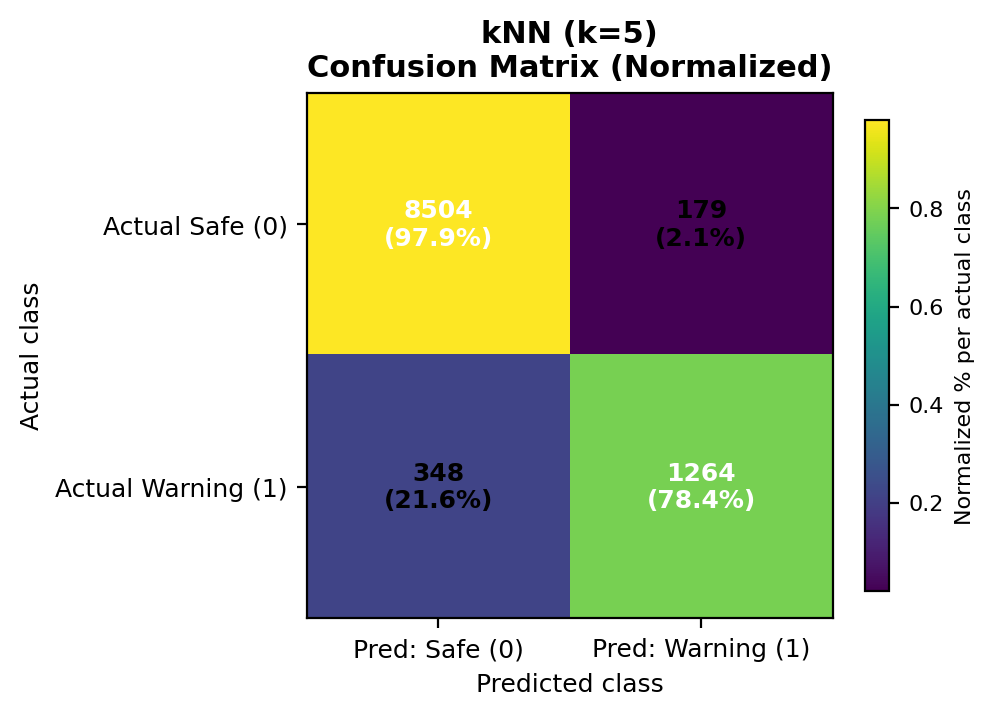

=== LogReg ===


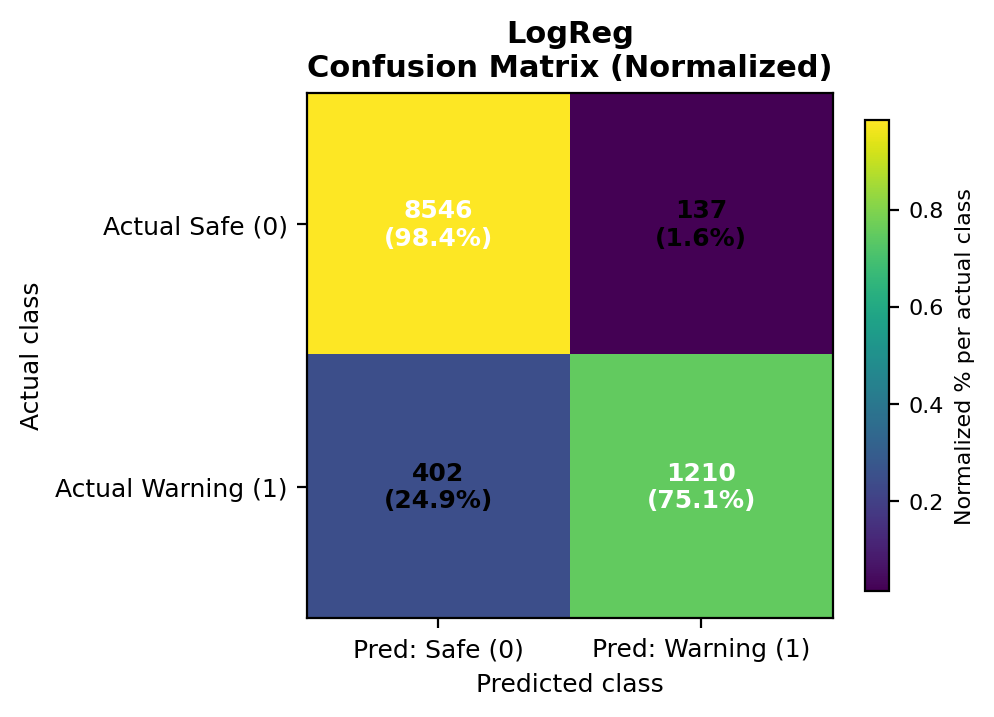

In [8]:
# === 6. Confusion Matrices for All Classifiers (High-Resolution Plots) ===
#
# This cell:
# - trains each classifier on (X_train_scaled, y_train_cls)
# - predicts on (X_val_scaled)
# - plots a high-quality confusion matrix heatmap for each model
#
# Classes:
#   0 = Safe (no urgent maintenance)
#   1 = Warning (RUL <= threshold, needs attention soon)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# 1. Define the models we want to compare
model_defs = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma=0.01),
    "kNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=1000)
}

# 2. Helper: plot confusion matrix for one model (high resolution for slides)
def plot_confusion_for_model(name, y_true, y_pred, save_fig=False):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # High-DPI figure -> sharper text and edges in screenshots / slides
    fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

    im = ax.imshow(cm_norm, interpolation='nearest')

    ax.set_title(f"{name}\nConfusion Matrix (Normalized)", fontsize=11, fontweight="bold")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Pred: Safe (0)', 'Pred: Warning (1)'], fontsize=9)
    ax.set_yticklabels(['Actual Safe (0)', 'Actual Warning (1)'], fontsize=9)

    # Put raw counts + % in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            pct = cm_norm[i, j] * 100.0
            ax.text(
                j, i,
                f"{count}\n({pct:.1f}%)",
                ha="center", va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black",
                fontsize=9,
                fontweight="bold",
                linespacing=1.2
            )

    ax.set_xlabel("Predicted class", fontsize=9)
    ax.set_ylabel("Actual class", fontsize=9)

    cbar = plt.colorbar(im, shrink=0.8)
    cbar.ax.set_ylabel("Normalized % per actual class", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()

    # Optional: save each plot as a high-quality PNG for slides/reports
    if save_fig:
        filename = f"confmat_{name.replace(' ','_').replace('(','').replace(')','')}.png"
        plt.savefig(filename, dpi=350, bbox_inches="tight")
        print(f"Saved {filename}")

    plt.show()

# 3. Train, predict, plot for each classifier
for name, model in model_defs.items():
    print(f"=== {name} ===")
    model.fit(X_train_scaled, y_train_cls)
    y_pred = model.predict(X_val_scaled)
    plot_confusion_for_model(name, y_val_cls, y_pred, save_fig=False)




# 7. Model Performance Summary (for CM1 slides)

This builds a comparison table of all classifiers on the warning_flag task.
You can screenshot the printed DataFrame or export it later.

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Define the models again (same as before)
models_clf = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma=0.01),
    "kNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# 2. Train/eval each model and store metrics
rows = []

for name, model in models_clf.items():
    # Fit on training data
    model.fit(X_train_scaled, y_train_cls)

    # Predict on validation data (unseen engines)
    y_pred = model.predict(X_val_scaled)

    # Compute metrics focused on the WARNING class = 1
    acc  = accuracy_score(y_val_cls, y_pred)
    prec = precision_score(y_val_cls, y_pred, pos_label=1)
    rec  = recall_score(y_val_cls, y_pred, pos_label=1)
    f1   = f1_score(y_val_cls, y_pred, pos_label=1)

    rows.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision (warning=1)": round(prec, 4),
        "Recall (warning=1)": round(rec, 4),
        "F1 (warning=1)": round(f1, 4),
    })

# 3. Create DataFrame
results_df = pd.DataFrame(rows)

# 4. Sort by F1 (best warning detector first)
results_df = results_df.sort_values(by="F1 (warning=1)", ascending=False)

print("=== Classification Model Summary on Validation Engines ===")
display(results_df)

=== Classification Model Summary on Validation Engines ===


,Model,Accuracy,Precision (warning=1),Recall (warning=1),F1 (warning=1)
0,Random Forest,0.9559,0.9055,0.8021,0.8507
2,kNN (k=5),0.9488,0.8760,0.7841,0.8275
1,SVM (RBF),0.9494,0.9092,0.7519,0.8231
3,Logistic Regression,0.9476,0.8983,0.7506,0.8178
